In [1]:
%matplotlib inline

from npnet import *
from utils import *

# Natural Parameter Networks: a Class of Probabilistic Natural Networks
## A paper by H. Wang, X. Shi and D.Y. Yeung [1]

In this presentation we will see a small overview of the so-called Natural Parameter Networks, or NPN. This is a work from 2016 by Wang, Shi and Yeung, presented in a paper for the NIPS (Neural Information Processing Systems) conference of the former year.

For the purpose of preparing this presentation I have reviewed the paper itself, the supplementary material and a spotlight video by the main author. I have also coded a basic implementation of the proposal with the hope that it will be useful to better illustrate NPNs, and I have even contacted the main author to gain more insight on more specific information about some topics.

# Motivation and goals

Learning framework that accomplishes:


- Explicit management of uncertainty

- Probabilistic Graphical Models' flexibility to fit distributions, but without sampling

- Same scalability as neural networks
    - Trainable via backpropagation

- Rich selection of distributions to choose for fitting the data: exponential family

So what are the ideas that have guided this work? The intention of the authors is to combine the best of Probabilistic Graphical Models and Neural Networks. More specifically this means that they want to explicitly manage the uncertainty about the network's prediction; have more or less the same flexibility to fit distributions as PGMs but skipping costly sampling methods; the scalability of neural networks, both for specifying the architecture and for the highly studied training methods; and finally, they also wish to have a wide selection of distributions to choose from to model the data. We will see that one of the strong points of NPNs is that, unlike some other bayesian-based neural networks, they can use any of the distributions of the exponential family.

# What are NPNs?

- In standard neural nets weights, biases and neuron values are real quantities.
- Weights, biases and neuron values are random variables that follow a distribution from the exponential family

| Standard Neural Net | Natural Parameter Net. Source: [2] |
|:-----:|:-----:|
| <img src="img/standard_nn.png" width="400px"> | <img src="img/npn_example.png" width="400px"> |

What is exactly an NPN? It is in essence a neural network in which both the neuron's values and the parameters are random variables. At the left we can see a representation of a regular neural net, with real values in both the neurons and the weights, and at the right we can see a NPN in which the neurons and the weights are random variables that have associated a certain distribution. So, we specify each weight and neuron with the parameters of the distribution associated to the random value, and this distributions are propagated up to the output layer.

# Exponential family

Exponential family distributions have the form:

$$ p(x | \boldsymbol{\eta}) = h(x) g(\boldsymbol{\eta}) exp(\boldsymbol{\eta}^T \mathbf{u}(x)) $$

Where $ \mathbf{\eta} $ consists of the natural parameters of the distribution. Examples of available distributions:

- Gaussian distribution

- Gamma distribution

- Beta distribution

- Poisson distribution

- Exponential distribution

In the context of the NPN frameworks we can use any of the distributions from the exponential family to model the neurons and the weights. These distributions have this form and are typically determined by two parameters. The parameters (the $ \boldsymbol{\eta} $ vector we can see in the slides) are the natural parameters that give the name to the framework. This family of distributions includes, but is not limited, to all the following distributions. Typically is enough with two parameters.

# Particularities of NPN


- Two times more parameters than in a NN with the same architecture.

- Feedforward and non-linear transforms are somewhat more complex. Resulting distributions are approximated by fitting a new exponential family distribution using the 1st and 2nd order moments.

- It is possible to come up with a set of equations for backpropagation. Gradient-based methods for training are applicable

- As for the error or loss function, one possibility is to apply Kullback-Leibler Divergence between the target distribution and the fitted distribution:

$$ D_{KL}(P\ ||\ Q) = \int_\mathbb{R} p(x) \log\left(\frac{p(x)}{q(x)}\right) \mathrm{d}x $$

One can calculate the close form of the KL loss for known distributions of the exponential family. E.g.: for Gaussians it can be proven that:

$$ D_{KL}(\mathcal{N}(\mu_1, \sigma_1^2), \mathcal{N}(\mu_2, \sigma_2^2)) = \frac{1}{2}\left[ \frac{(\mu_2 - \mu_1)^2}{\sigma_2^2} + \frac{\sigma_1^2}{\sigma_2^2} - 1 - \log\left(\frac{\sigma_1^2}{\sigma_2^2}\right) \right] $$

These are some of the particularities of NPN:

- They require twice the number of parameters than NN with the same architecture.
- Special care has to be taken when performing the feedforward and non-linear transformations of the distributions.
- It is possible to perform backpropagation much like in regular neural nets.
- And loss or error functions should measure the difference between probability distributions rather than point estimates. An example of such function is the KL divergence that we have seen in the course, it has this form for continuous variables and this is the closed expression for Gaussian distributions.


# Example: regression task

We provide an experimental implementation of the proposed method, using Gaussian distributions and sigmoid activation functions.


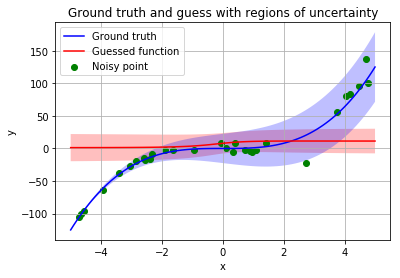

In [9]:
# toy regression task
np.random.seed(42)
npn = NPNet([1, 100, 1], ['sigmoid', 'linear'], 'gaussian', std0=1.0)
np.random.seed(73)
f = lambda x: np.power(x, 3)
g = lambda x: np.power(x+5.0, 1.25)
x, y = sample_function(-5, 5, 30, f, g)
# show without training (NPN with random weights and biases)
plt.show(plot_truth_and_guess(f, g, x, y, npn))

Let us review as an example a toy regression problem. I have prepared these examples with my implementation.

Here we have a continuous function in blue. The shaded region represents three times the deviation of the sampled points for that x. The red line represents the function expressed by an untrained randomized NPN with just one hidden layer with 100 neurons, and the shaded region is the deviation estimate. The green points (30 in total) represent a random sample of the function we want to approximate.

We will see how the net evolves after 100 iterations of Gradient Descent...

After 500...

And after 1000 iterations. We can see how the estimated means follows more or less the ground truth and the variance of the sample points (the shaded area is thinner at the left and thicker at the right).

100 iterations of GD


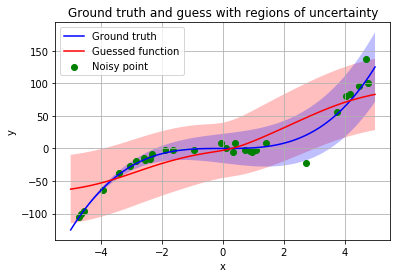

In [10]:
npn.train(x, y, eta=1e-1, max_iterations=100, sigma=0.0)
print("100 iterations of GD")
plt.show(plot_truth_and_guess(f, g, x, y, npn))

500 iterations of GD


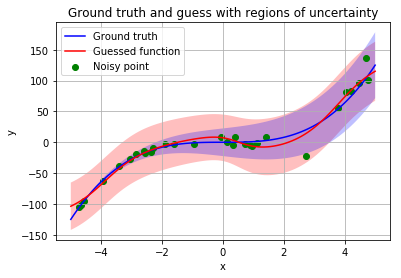

In [11]:
print("500 iterations of GD")
npn.train(x, y, eta=1e-1, max_iterations=400, sigma=0.0)
plt.show(plot_truth_and_guess(f, g, x, y, npn))

1000 iterations of GD


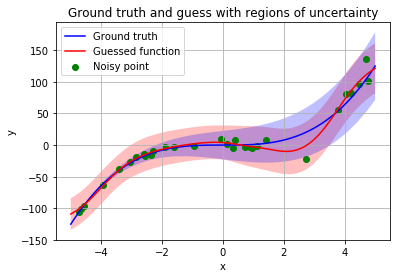

In [12]:
print("1000 iterations of GD")
npn.train(x, y, eta=1e-1, max_iterations=500, sigma=0.0)
plt.show(plot_truth_and_guess(f, g, x, y, npn))

# Example: regularization

It is possible to train with regularization, imposing priors $ \mathcal{N}(0, \lambda_s^{-1}) $ to the weights. Previous result:

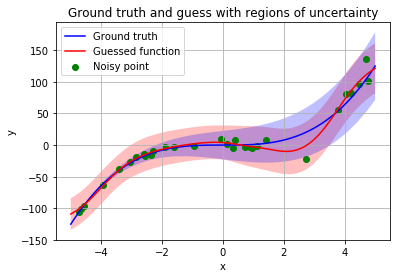

In [13]:
plt.show(plot_truth_and_guess(f, g, x, y, npn))

In [15]:
%reset -f
from npnet import *
from utils import *

Result with regularization:

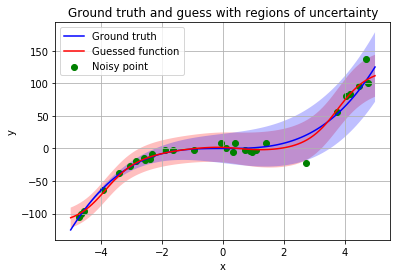

In [16]:
np.random.seed(42)
npn = NPNet([1, 100, 1], ['sigmoid', 'linear'], 'gaussian', std0=1.0)
np.random.seed(73)
f = lambda x: np.power(x, 3)
g = lambda x: np.power(x+5.0, 1.25)
x, y = sample_function(-5, 5, 30, f, g)
npn.train(x, y, eta=1e-1, max_iterations=1000, sigma=0.0, lambda_s=1e-3) # Added lambda_s parameter
plt.show(plot_truth_and_guess(f, g, x, y, npn))

This example simply illustrates that we can use regularization to control the complexity of the network, much like in regular neural nets.

# Results
## Classification: MNIST

Tested against MNIST dataset. Results extracted from the work of Wang and others [1, 3]:

|Method|BDK|BBB|Dropout1|Dropout2|gamma NPN|Gaussian NPN|
|------:|---:|---:|--------:|--------:|---------:|------------:|
|**Error**|1.38%|1.34%|1.33%|1.40%|1.27%|1.25%|

|Size|100|500|2000|10000|
|--------|---|---|----|-----|
|**NPN**|29.97%|13.79%|7.89%|3.28%|
|**Dropout**|32.58%|15.39%|8.78%|3.53%|
|**BDK**|30.08%|14.34%|8.31%|3.55%|

These are some classification results directly extracted from the paper and that use the well-known MNIST dataset. These results show that, even if NPNs do not vastly outperform current state of the art techniques for classification, they can keep it up with them.

# Results
## Variance as a means to assess accuracy of prediction

The output variance is an effective proxy to assess the certainty that the network has on its own predictions:

| Output variance vs accuracy (MNIST). Source: [3] | Output variance vs Reconstruction Error (Second-Order Representation Learning) Source: [3] |
|:-----:|:-----:|
| <img src="img/mnist_var_acc.png" width="80%"> | <img src="img/repr_var_acc.png" width="80%"> |

And this is what I think it is more interesting: the predicted variance gives us an idea of the certainty that the network has in it own predictions, since it seems to be correlated with the performance function. At the left we can see the relation between the variance and the error in the classification MNIST task while at the right we can see the reconstruction error w.r.t. to the variance in a unsupervised representational learning task.

# Conclusions

- The paper and the supplementary material give enough details to implement NPN. No implementation by the authors is available yet.

- The results in terms of accuracy (classification), RMS (regression) and reconstruction error (second order learning) are competitive with those in the recent literature.

- Output variance gives a good idea about how accurate is the network's prediction

The summary of the discussed framework is presented in this slide:

- There are enough details in the paper to implement them
- It is competitive with techniques in recent literature
- And the output variance is an effective proxy to assess how much should we trust the network's prediction.

# References

[1] Wang, H., Shi, X., & Yeung, D.-Y. (2016). Natural-Parameter Networks: A Class of Probabilistic Neural Networks, (1), 1–9. Retrieved from http://arxiv.org/abs/1611.00448

[2] Wang, H., Natural Parameter Networks: a Class of Probabilistic Neural Networks - NIPS 2016 spotlight video, https://www.youtube.com/watch?v=evfU0uEXPC8

[3] Wang, H., Shi, X., & Yeung, D. (2016). Supplementary Materials for Natural-Parameter Networks: A Class of Probabilistic Neural Networks.